In [1]:
# horse-or-human classification model with CNN
# train : 1027 images [horse(500) + human(527)] , 300*300 pixels
# validation : 256 images [horse(128) + human(128)] , 300*300 pixels

In [2]:
import tensorflow as tf
import urllib
import zipfile

In [3]:
# horse-or-human 데이터셋 다운로드
_TRAIN_URL = "https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip"
_TEST_URL = "https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip"
urllib.request.urlretrieve(_TRAIN_URL, 'horse-or-human.zip')
urllib.request.urlretrieve(_TEST_URL, 'validation-horse-or-human.zip')

# 새로운 데이터 다운로드 주소
# https://storage.googleapis.com/learning-datasets/horse-or-human.zip

('validation-horse-or-human.zip', <http.client.HTTPMessage at 0x1dbbea272e0>)

In [4]:
# Colab용 : Linux/GPU사용 
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
#     -O /tmp/horse-or-human.zip

# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
#     -O /tmp/validation-horse-or-human.zip

# Colab용 : Linux/GPU사용 
# !wget --no-check-certificate \
#     https://storage.googleapis.com/learning-datase/horse-or-human.zip \
#     -O /tmp/horse-or-human.zip

# !wget --no-check-certificate \
#     https://storage.googleapis.com/learning-datase/validation-horse-or-human.zip \
#     -O /tmp/validation-horse-or-human.zip

In [5]:
# 압축해제
local_zip = 'horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('tmp/horse-or-human/')
zip_ref.close()

local_zip = 'validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('tmp/validation-horse-or-human/')
zip_ref.close()

train_dir = 'tmp/horse-or-human/'
validation_dir = 'tmp/validation-horse-or-human/'

In [6]:
# 이미지 데이터 경로 설정
import os

# Directory with our training horse pictures
train_horse_dir = os.path.join('tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('tmp/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('tmp/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('tmp/validation-horse-or-human/humans')

train_horse_names = os.listdir(train_horse_dir)
# print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
# print(train_human_names[:10])

validation_horse_names = os.listdir(validation_horse_dir)
# print(validation_horse_names[:10])

validation_human_names = os.listdir(validation_human_dir)
# print(validation_human_names[:10])

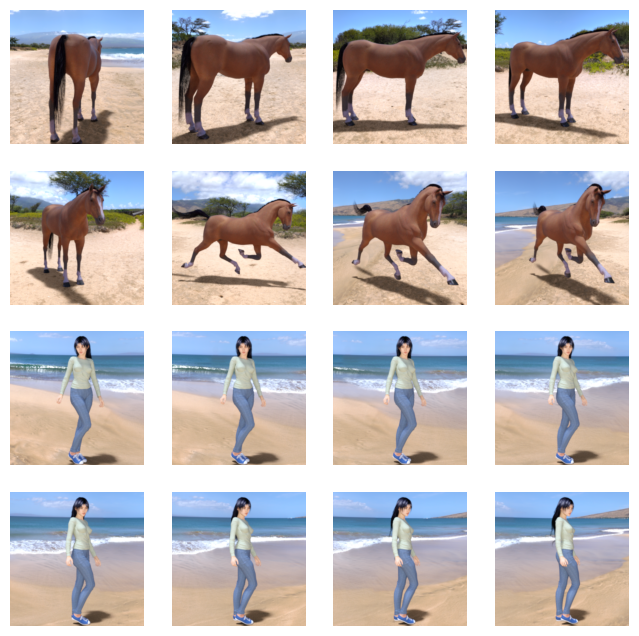

In [7]:
# 데이터 시각화 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 15  # 시작 인덱스

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*2, nrows*2)
pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

# print(next_horse_pix)
# print(next_human_pix)

for i, img_path in enumerate(next_horse_pix+next_human_pix):  # 16회 반복
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [20]:
# map()함수
import numpy as np
def multiple(a):
    print('multiple function is called!!')
    return a*2

print(multiple(np.array([10,20])))

# for k in [10,20,30]:
#     print(multiple(k))
    
ret = map(multiple,[10,20,30])
print(ret)
print(list(ret))

multiple function is called!!
[20 40]
multiple function is called!!
multiple function is called!!
multiple function is called!!
[20, 40, 60]


In [26]:
ret = map(multiple,[10,20,30])
print(dir(ret)) # '_next_'
next(ret)

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__ne__', '__new__', '__next__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
multiple function is called!!


20

In [23]:
next(ret)

multiple function is called!!


40

In [24]:
next(ret)

multiple function is called!!


60

In [27]:
# next(ret)

### 데이터 전처리 : 이미지 증강(Image Augmentation)

In [36]:
# 참고 소스
# ! pip install Augmentor
import Augmentor

# ! mkdir augmentation_test

# 증강 시킬 이미지 폴더 경로
img = Augmentor.Pipeline('augmentation_test/')

# 좌우 반전
img.flip_left_right(probability=1.0)

# 상하 반전
img.flip_top_bottom(probability=1.0)

# 왜곡
img.random_distortion(probability=1.0,grid_width=10,grid_height=10,magnitude=8)

# 증강 이미지수--> 증강 실행
img.sample(100)

Initialised with 2 image(s) found.
Output directory set to augmentation_test/output.

Processing <PIL.Image.Image image mode=RGBA size=257x252 at 0x1DBC3E1CB20>: 100%|█| 100/100 [00:00<00:00, 331.13 Sample


## CNN Model 구현

In [37]:
from tensorflow.keras.optimizers import RMSprop

In [43]:
# Conv-MaxPool2D * 5회 : 16-32-64-64-64 , filter:(3,3), strides:1, 패딩없음
#                                         poolsize : (2,2), strides:2, 패딩없음
# Dense * 2회          :  Hidden Layer Output : 512
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),
                           activation='relu',input_shape=(300`,300,3)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(units=512,activation='relu'),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
    
])

#  RMSprop, Learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 149, 149, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 35, 35, 64)      

### 텐서플로 이미지 증강 구현

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
type(train_datagen)

validation_datagen = ImageDataGenerator(rescale=1./255)

# train data의 generator
train_generator = train_datagen.flow_from_directory(
                  train_dir, # 이미지 파일 디렉터리 경로
                  target_size=(300,300),
                  batch_size=128,
                  class_mode='binary') # 2진 분류

# validation data의 generator

validation_generator = validation_datagen.flow_from_directory(
                  validation_dir, # 이미지 파일 디렉터리 경로
                  target_size=(300,300),
                  batch_size=32,
                  class_mode='binary') # 2진 분류

print(train_generator)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [51]:
# 학습
history = model.fit(
            train_generator, # X
            steps_per_epoch=8, # 1027(train image number)/128(train batch_size) 생략해도 자동으로 내부에서 계산
            epochs = 15,
            validation_data=validation_generator,
            validation_steps=8) #256/32


Epoch 1/15
8/8 [==============================] - 11s 537ms/step - loss: 0.9697 - accuracy: 0.5551 - val_loss: 0.6237 - val_accuracy: 0.5781
Epoch 2/15
8/8 [==============================] - 4s 481ms/step - loss: 0.7309 - accuracy: 0.6340 - val_loss: 0.5591 - val_accuracy: 0.7148
Epoch 3/15
8/8 [==============================] - 4s 459ms/step - loss: 0.5380 - accuracy: 0.8120 - val_loss: 3.2276 - val_accuracy: 0.5000
Epoch 4/15
8/8 [==============================] - 4s 478ms/step - loss: 0.7694 - accuracy: 0.7430 - val_loss: 1.6563 - val_accuracy: 0.6055
Epoch 5/15
8/8 [==============================] - 4s 481ms/step - loss: 0.6721 - accuracy: 0.8198 - val_loss: 0.3739 - val_accuracy: 0.8711
Epoch 6/15
8/8 [==============================] - 4s 476ms/step - loss: 0.2073 - accuracy: 0.9321 - val_loss: 1.3240 - val_accuracy: 0.8008
Epoch 7/15
8/8 [==============================] - 4s 519ms/step - loss: 0.1586 - accuracy: 0.9355 - val_loss: 0.8966 - val_accuracy: 0.8711
Epoch 8/15
8/8 [===

### 학습 결과 시각화

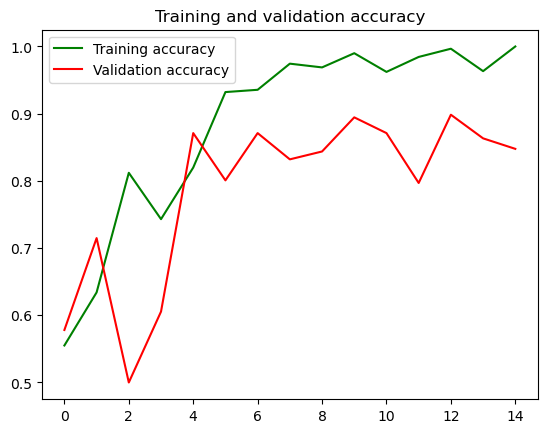

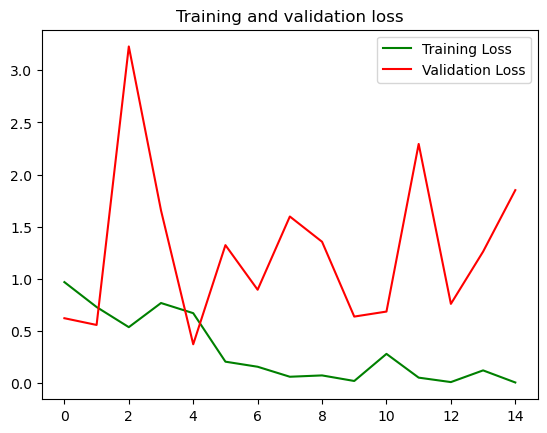

In [53]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 이미지 분류 예측

In [54]:
# 참고 소스
import numpy as np
from tensorflow.keras.preprocessing import image
def image_predict(file_name):
    path = 'horse-or-human예측용이미지/' + file_name
    img = image.load_img(path, target_size=(300, 300))
    x = image.img_to_array(img)   # 2차원 ndarray로 변환
    x = np.expand_dims(x, axis=0) # 3차원으로 변환
    images = np.vstack([x])       # 4차원으로 변환
    classes = model.predict(images, batch_size=10)
    if classes[0] == 1.0:
        print(file_name ,': human')
    else:
        print(file_name ,': horse')
        
image_predict('말01.jpg')        
image_predict('말02.jpg') 
image_predict('기린.jpg')
image_predict('말과사람.jpg')
image_predict('말과사람02.jpg')
image_predict('말과사람06.jpg')
image_predict('사람01.jpg')
image_predict('사람02.jpg')
image_predict('사람12.jpg')
image_predict('말타기게임하는사람.jpg')

1/1 [==============================] - 0s 391ms/step
말01.jpg : horse
1/1 [==============================] - 0s 12ms/step
말02.jpg : horse
1/1 [==============================] - 0s 12ms/step
기린.jpg : horse
1/1 [==============================] - 0s 13ms/step
말과사람.jpg : horse
1/1 [==============================] - 0s 12ms/step
말과사람02.jpg : human
1/1 [==============================] - 0s 11ms/step
말과사람06.jpg : horse
1/1 [==============================] - 0s 12ms/step
사람01.jpg : horse
1/1 [==============================] - 0s 11ms/step
사람02.jpg : human
1/1 [==============================] - 0s 13ms/step
사람12.jpg : horse
1/1 [==============================] - 0s 12ms/step
말타기게임하는사람.jpg : horse


### 모델 개선

In [55]:
# ! mkdir tmp\saved_train_image
# ! mkdir tmp\saved_val_image

In [59]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

# train data의 generator
train_generator = train_datagen.flow_from_directory(
                  train_dir, # 이미지 파일 디렉터리 경로
                  target_size=(300,300),
                  batch_size=20,
                  class_mode='binary', # 2진 분류
                  save_to_dir='tmp/saved_train_image')
    

# validation data의 generator
validation_generator = validation_datagen.flow_from_directory(
                  validation_dir, # 이미지 파일 디렉터리 경로
                  target_size=(300,300),
                  batch_size=20,
                  class_mode='binary', # 2진 분류
                  save_to_dir='tmp/saved_val _image')
    
print(train_generator)
train_datagen = ImageDataGenerator(rescale=1./255)
type(train_datagen)

validation_datagen = ImageDataGenerator(rescale=1./255)


# DirectoryIterator object  , 실제 사용 시점(학습시)에 데이터 생성
# fit 호출시 1 epoch 마다 train 이미지 1027개 생성  : 15 epochs 일 경우 총 15*1027 증강 이미지 생성
# fit 호출시 1 epoch 마다 validation 이미지 256개 생성  : 15 epochs 일 경우 총 15*256 증강 이미지 생성

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [60]:
# 모델 구현
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(300,300,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')    
])

#  RMSprop, Learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 149, 149, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 35, 35, 64)      

In [61]:
# 학습 
history = model.fit(
        train_generator, # X
        steps_per_epoch=50,  # 1027/20, train image number/train batch_size
        epochs=10,
        verbose=1,
        validation_data=validation_generator,
        validation_steps=12)  # 256/20, validation image number/validation batch_size

Epoch 1/10
50/50 [==============================] - 44s 850ms/step - loss: 2.7470 - accuracy: 0.6373 - val_loss: 1.3109 - val_accuracy: 0.5000
Epoch 2/10
50/50 [==============================] - 43s 858ms/step - loss: 0.5595 - accuracy: 0.7275 - val_loss: 1.4479 - val_accuracy: 0.5708
Epoch 3/10
50/50 [==============================] - 43s 853ms/step - loss: 0.4976 - accuracy: 0.7862 - val_loss: 2.3353 - val_accuracy: 0.5750
Epoch 4/10
50/50 [==============================] - 43s 860ms/step - loss: 0.4045 - accuracy: 0.8136 - val_loss: 2.5610 - val_accuracy: 0.6000
Epoch 5/10
50/50 [==============================] - 43s 854ms/step - loss: 0.3514 - accuracy: 0.8521 - val_loss: 3.5865 - val_accuracy: 0.5583
Epoch 6/10
50/50 [==============================] - 43s 846ms/step - loss: 0.2859 - accuracy: 0.8754 - val_loss: 5.1073 - val_accuracy: 0.5417
Epoch 7/10
50/50 [==============================] - 42s 845ms/step - loss: 0.2449 - accuracy: 0.9129 - val_loss: 3.3667 - val_accuracy: 0.6375